# Housing Price Forecasting 

![](https://i.pinimg.com/originals/96/14/09/961409afcab1ce8a77fa4894b5faf2a6.jpg)

The real estate market can be unpredictable and challenging to navigate for both buyers and sellers. It can be difficult to determine whether a property is a good investment, and market fluctuations can make it challenging to predict future prices. Therefore, having accurate insights into housing prices and trends can be incredibly valuable for making informed decisions.

In this project, we aim to analyze and predict housing prices for a specific region using historical sales data from 2007-2019. Our objective is to develop a model that can accurately predict prices for the next year, taking into account factors such as property type, number of bedrooms, and location. Additionally, we aim to provide insights into the trends and patterns of housing prices over time in the specific region.

To accomplish this, we will use SARIMA and Prophet library to analyze the data and develop a model that can predict future prices. These techniques are powerful tools for time-series analysis, and they can provide valuable insights into the complex patterns and trends of housing prices.

By leveraging data analysis and machine learning techniques, we can provide valuable insights and predictions in the real estate market. This information can be useful for buyers, sellers, and real estate professionals in making informed decisions about property investments.




In [2]:
##Import the required libraries

from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline
import seaborn as sns
from pylab import rcParams
from math import sqrt
from sklearn.metrics import  mean_squared_error
import warnings
warnings.filterwarnings(action='ignore')
from pandas.tseries.offsets import BDay 
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar()) 
rcParams['figure.figsize'] = 15,8

In [3]:
# readingthe csv file 
df_final = pd.read_csv('archive/raw_sales.csv',parse_dates=['datesold'],index_col='datesold')

In [4]:
df_final.head()

postcode   price propertyType  bedrooms
datesold                                           
2007-02-07      2607  525000        house         4
2007-02-27      2906  290000        house         3
2007-03-07      2905  328000        house         3
2007-03-09      2905  380000        house         4
2007-03-21      2906  310000        house         3

In [5]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29580 entries, 2007-02-07 to 2019-07-26
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   postcode      29580 non-null  int64 
 1   price         29580 non-null  int64 
 2   propertyType  29580 non-null  object
 3   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [6]:
df_final.isna().any()

postcode        False
price           False
propertyType    False
bedrooms        False
dtype: bool

In [7]:
df_final.describe(include='all')

postcode         price propertyType      bedrooms
count   29580.000000  2.958000e+04        29580  29580.000000
unique           NaN           NaN            2           NaN
top              NaN           NaN        house           NaN
freq             NaN           NaN        24552           NaN
mean     2730.249730  6.097363e+05          NaN      3.250169
std       146.717292  2.817079e+05          NaN      0.951275
min      2600.000000  5.650000e+04          NaN      0.000000
25%      2607.000000  4.400000e+05          NaN      3.000000
50%      2615.000000  5.500000e+05          NaN      3.000000
75%      2905.000000  7.050000e+05          NaN      4.000000
max      2914.000000  8.000000e+06          NaN      5.000000

In [8]:
df_final.bedrooms.replace({0:np.nan},inplace=True)


In [9]:

df_final=df_final.dropna()

In [94]:
# The point estimate is typically represented as a dot or a symbol at the center of each group of points,
# while the uncertainty is represented using error bars or confidence intervals. By default, the point 
# estimate is the mean of the numeric variable. 
# pointplots are useful for comparing the distribution of a numeric variable across different categories
# and for detecting differences or similarities in the distribution. 

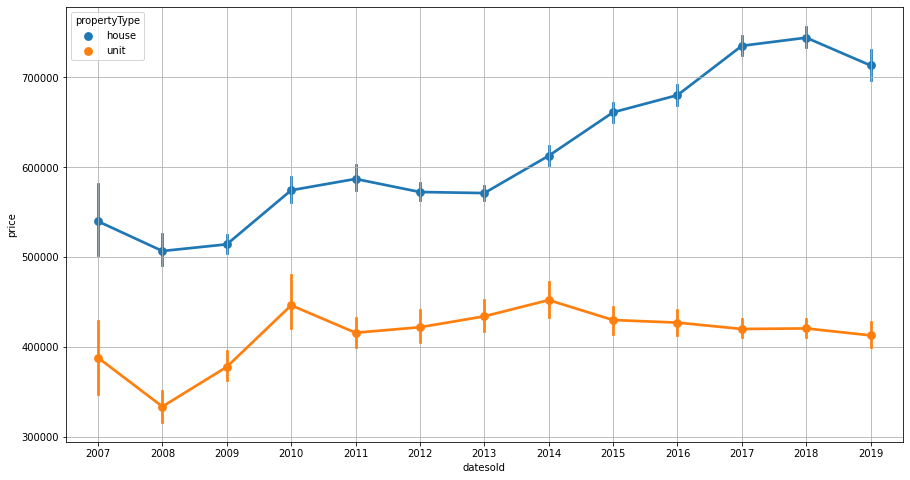

In [92]:
sns.pointplot(data=df_final,y='price',x=df_final.index.year,hue='propertyType');
plt.grid()

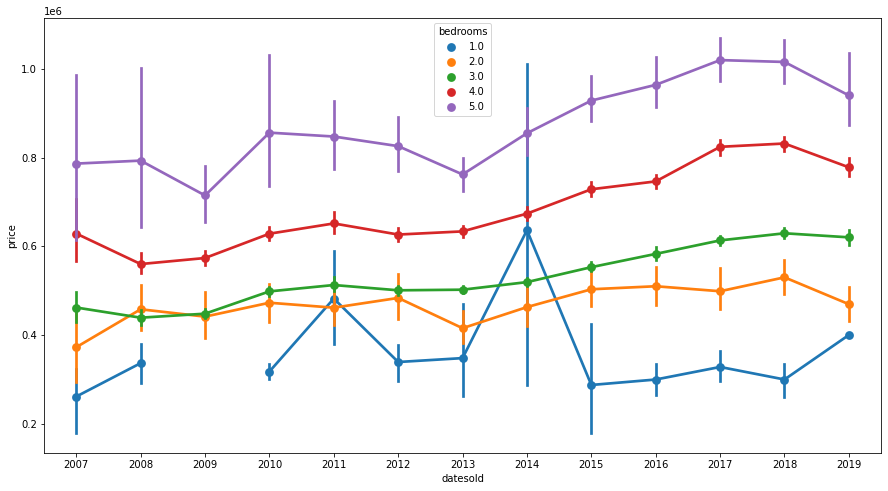

In [11]:
sns.pointplot(data=df_final[df_final.propertyType=='house'],y='price',x=df_final[df_final.propertyType=='house'].index.year,hue='bedrooms');


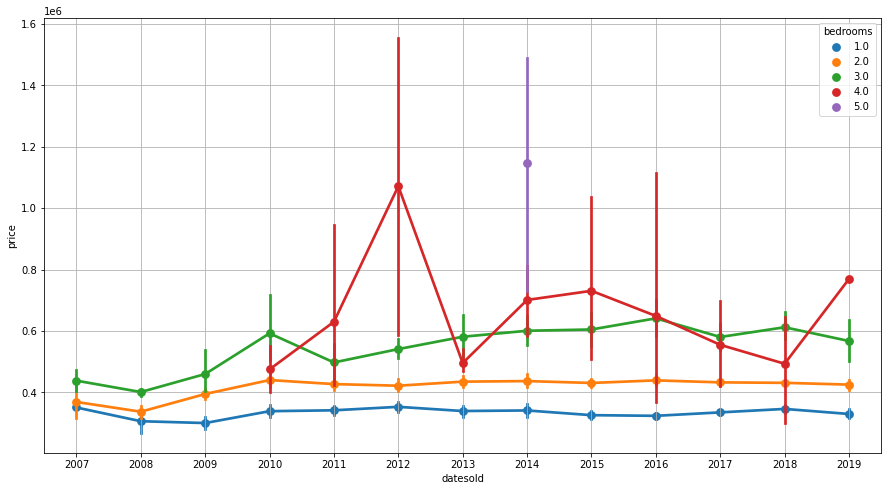

In [12]:
sns.pointplot(data=df_final[df_final.propertyType=='unit'],y='price',x=df_final[df_final.propertyType=='unit'].index.year,hue='bedrooms');
plt.grid()

houses with 5 bedrooms and 2603 postcode has the higher price. 

## Creating the dataframe from housing type and rooms number

<AxesSubplot: xlabel='bedrooms', ylabel='propertyType'>

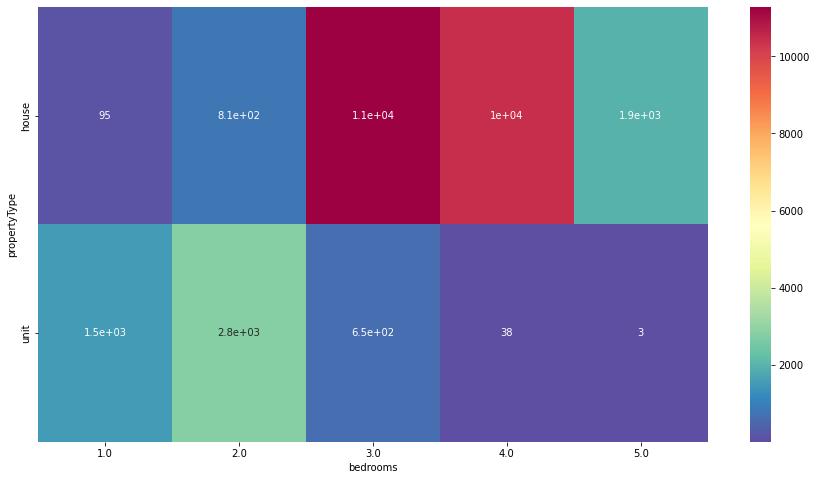

In [99]:
table=pd.pivot_table(data=df_final,index='propertyType',columns='bedrooms',values='price',aggfunc='count')
sns.heatmap(table,cmap='Spectral_r',annot=True)

**Observation:** Houses with 3 bedrooms are the most popular in the real estates market

In [95]:
# choose bedroom=3,and type=house to continue the process  
df_price=df_final[(df_final['propertyType']=='house' )&	(df_final['bedrooms']==3)][['price']]
df=df_price.resample('M').mean().interpolate(method='linear', limit_direction='both')


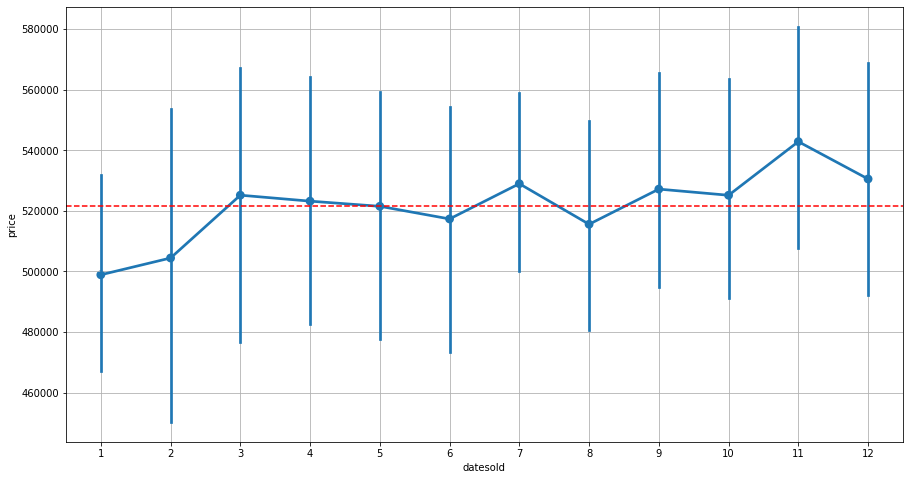

In [17]:
#Plot the price respect to the month and the red line is the average
sns.pointplot(data=df,x = df.index.month,y = df['price'])
plt.axhline(y=df['price'].mean(), color='r', linestyle='--')
plt.grid();

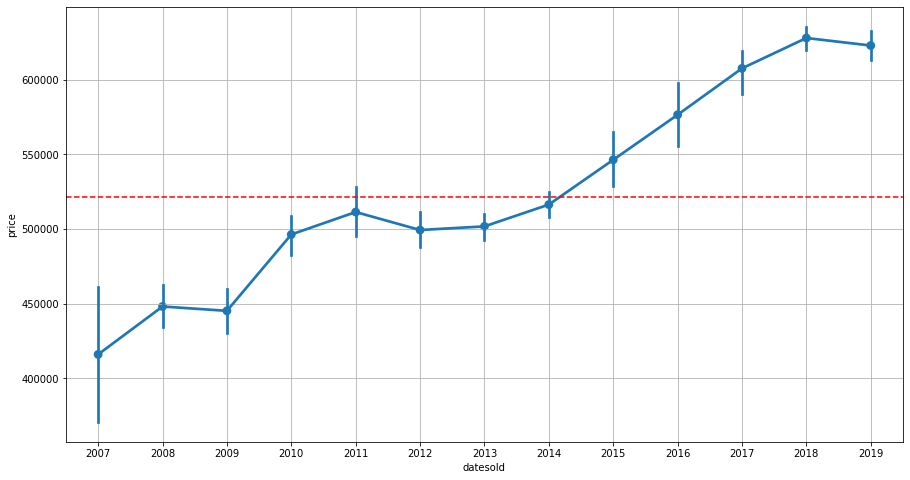

In [18]:
#Plot the price respect to the years the red line is the average
sns.pointplot(x = df.index.year,y = df['price'])
plt.axhline(y=df['price'].mean(), color='r', linestyle='--')
plt.grid();

In [19]:
df_date2=df[['price']].copy()


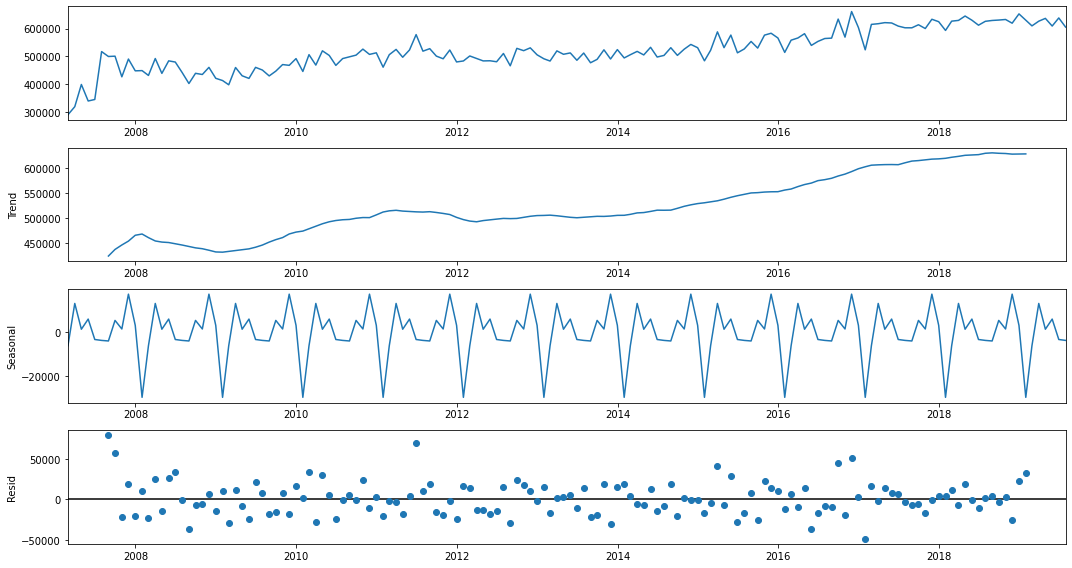

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_date2,model='additive')
decomposition.plot();


# Check for stationarity of the series at $\alpha$ = 0.05 using appropriate statistical tests.

In [21]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

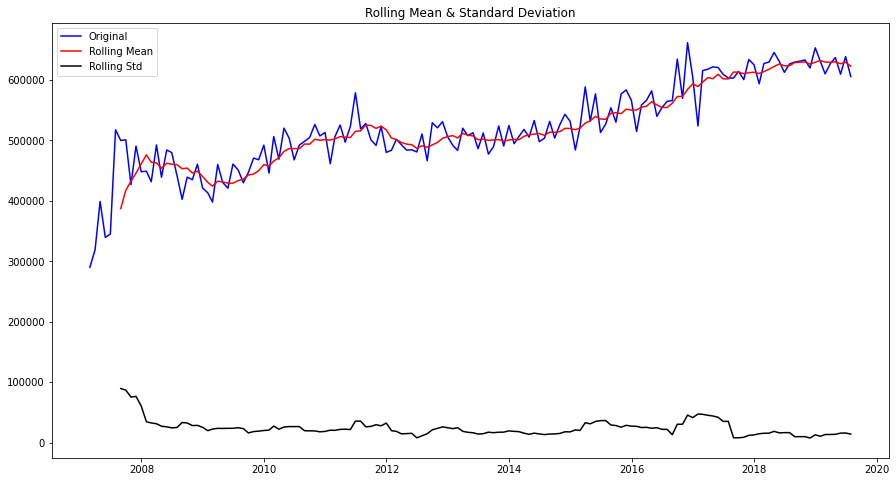

Results of Dickey-Fuller Test:
Test Statistic                  -1.234755
p-value                          0.658469
#Lags Used                       5.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64 



In [22]:
test_stationarity(df_date2)

**Observation**
the data is not stationary. To make it stationary shift by 1

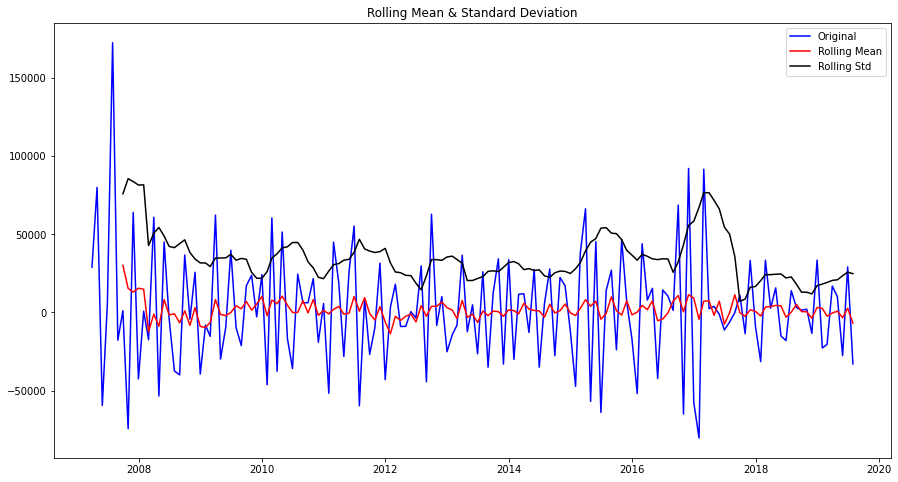

Results of Dickey-Fuller Test:
Test Statistic                -8.535774e+00
p-value                        1.008986e-13
#Lags Used                     4.000000e+00
Number of Observations Used    1.440000e+02
Critical Value (1%)           -3.476598e+00
Critical Value (5%)           -2.881829e+00
Critical Value (10%)          -2.577589e+00
dtype: float64 



In [23]:
test_stationarity(df_date2.diff(1).dropna())

**Observation** P-values < 0.05. Now it is stationaly 

In [24]:
train=df_date2[df_date2.index <='2016-06-01']
test=df_date2[df_date2.index >'2016-06-01']

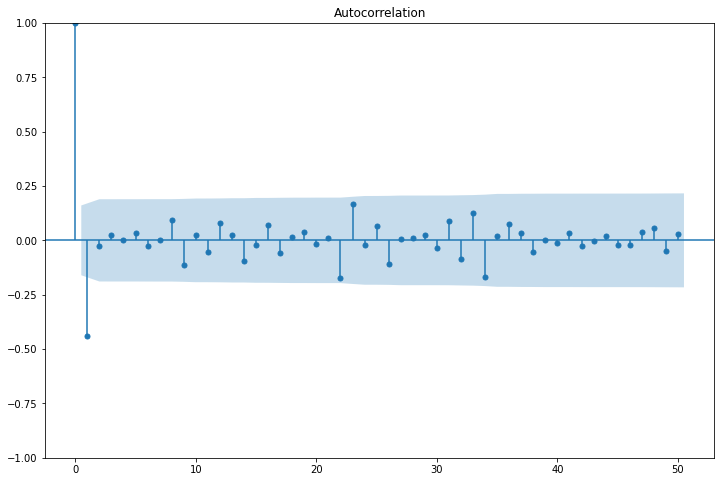

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,8))
plot_acf(df_date2.diff(1).dropna(),lags=50, zero=True, ax=plt.gca()) 
plt.show()

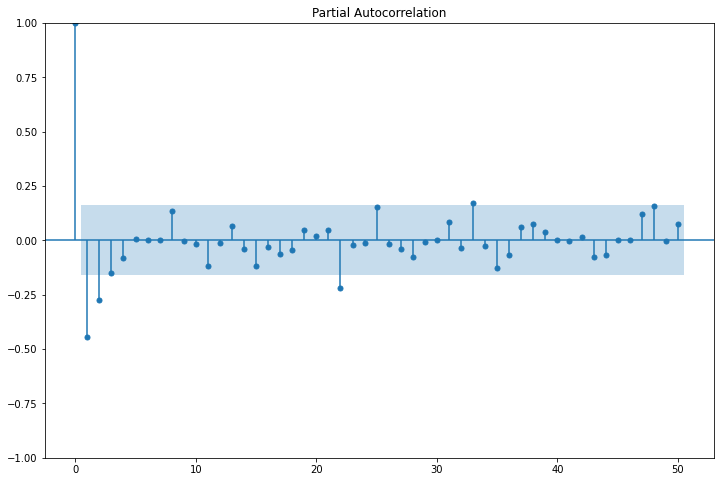

In [26]:
plt.figure(figsize=(12,8))
plot_pacf(df_date2.diff(1).dropna(),lags=50, ax=plt.gca(),zero=True) 
plt.show()

In [27]:
import statsmodels.api as sm

In [28]:
import itertools
p=q=range(0,3)

d= range(1,2)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # from autocorrelation function ,d=0 becuase it 's stationary
print('Examples of parameter combinations for Model...')
print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4]))

Examples of parameter combinations for Model...
Model: (0, 1, 1)(0, 1, 1, 12)
Model: (0, 1, 1)(0, 1, 2, 12)
Model: (0, 1, 2)(1, 1, 0, 12)
Model: (0, 1, 2)(1, 1, 1, 12)


## What is (p,d,q)(P,D,Q)m?
* p: The number of autoregressive terms (lags of the dependent variable) included in the model.
* d: The number of times the data needs to be differenced to make it stationary (i.e., have a constant mean and variance).
* q: The number of moving average terms (lags of the error term) included in the model.
* P: The number of seasonal autoregressive terms (lags of the dependent variable at the seasonal frequency) included in the model.
* D: The number of times the seasonal data needs to be differenced to make it stationary.
* Q: The number of seasonal moving average terms (lags of the error term at the seasonal frequency) included in the model.
* m: The number of time periods in each season.


# Build a SARIMA model with the parameters selected in accordance with the lowest AIC and evaluate the same on the test data with respect to RMSE.
Autoregressive (AR) terms in a SARIMA model represent the lagged values of the dependent variable, i.e., the values from previous time periods. An AR term of order p includes p lagged values of the dependent variable in the model.

What is  Akaike Information Criterion (AIC)?


AIC is calculated based on the log-likelihood of the data and the number of parameters in the model. AIC penalizes models that have more parameters, which means that it favors simpler models over complex ones. The lower the AIC value, the better the model is considered to fit the data.

AIC is defined as follows:

AIC = 2k - 2ln(L)

where k is the number of parameters in the model and L is the maximum value of the likelihood function for the model. The likelihood function is a measure of how well the model fits the data. The first term of the equation, 2k, represents the penalty for having more parameters in the model, and the second term, 2ln(L), represents the goodness of fit of the model.

Therefore, when comparing different models for a given set of data, the model with the lowest AIC value is considered the best fit for the data.

In [29]:
SARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
print(SARIMA_AIC)

Empty DataFrame
Columns: [param, AIC]
Index: []


In [30]:
for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['price'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit()
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 1, 0, 12)7 - AIC:2399.1864551710414
SARIMA(0, 1, 0)x(0, 1, 1, 12)7 - AIC:2042.5576047100003
SARIMA(0, 1, 0)x(0, 1, 2, 12)7 - AIC:1754.3758902106301
SARIMA(0, 1, 0)x(1, 1, 0, 12)7 - AIC:2091.0849764722543
SARIMA(0, 1, 0)x(1, 1, 1, 12)7 - AIC:2041.444282398481
SARIMA(0, 1, 0)x(1, 1, 2, 12)7 - AIC:1753.005636371907
SARIMA(0, 1, 0)x(2, 1, 0, 12)7 - AIC:1785.8841696820205
SARIMA(0, 1, 0)x(2, 1, 1, 12)7 - AIC:1776.8473548196216
SARIMA(0, 1, 0)x(2, 1, 2, 12)7 - AIC:1751.6973261910744
SARIMA(0, 1, 1)x(0, 1, 0, 12)7 - AIC:2342.3140246636017
SARIMA(0, 1, 1)x(0, 1, 1, 12)7 - AIC:2008.2328216494573
SARIMA(0, 1, 1)x(0, 1, 2, 12)7 - AIC:1722.1759694779391
SARIMA(0, 1, 1)x(1, 1, 0, 12)7 - AIC:2063.3423449552633
SARIMA(0, 1, 1)x(1, 1, 1, 12)7 - AIC:2009.959828951779
SARIMA(0, 1, 1)x(1, 1, 2, 12)7 - AIC:1724.1472395521912
SARIMA(0, 1, 1)x(2, 1, 0, 12)7 - AIC:1772.3531046449318
SARIMA(0, 1, 1)x(2, 1, 1, 12)7 - AIC:1774.0306716035427
SARIMA(0, 1, 1)x(2, 1, 2, 12)7 - AIC:1725.960360400

c:\Users\Rayan\.conda\envs\pgds_program\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(2, 1, 2, 12)7 - AIC:1696.818166977354


In [31]:
SARIMA_AIC.sort_values(by='AIC',ascending=True)

param          AIC       seasonal
20  (0, 1, 2)  1679.680065  (0, 1, 2, 12)
47  (1, 1, 2)  1681.273320  (0, 1, 2, 12)
23  (0, 1, 2)  1681.678703  (1, 1, 2, 12)
74  (2, 1, 2)  1683.315904  (0, 1, 2, 12)
26  (0, 1, 2)  1683.580112  (2, 1, 2, 12)
..        ...          ...            ...
54  (2, 1, 0)  2343.065579  (0, 1, 0, 12)
36  (1, 1, 1)  2343.470503  (0, 1, 0, 12)
63  (2, 1, 1)  2344.289920  (0, 1, 0, 12)
27  (1, 1, 0)  2378.668064  (0, 1, 0, 12)
0   (0, 1, 0)  2399.186455  (0, 1, 0, 12)

[81 rows x 3 columns]

**SARIMA(0,1,2)(0,1,2,12)** means that the model includes:

2 moving average terms (q=2) and 1 non-seasonal difference (d=1) to make the data stationary.
2 seasonal moving average terms (Q=2) and 1 seasonal difference (D=1) at a seasonal frequency of 12 (i.e., 12 months) to make the seasonal data stationary.
There are no autoregressive or seasonal autoregressive terms included in the model (p=0, P=0).


Autoregressive (AR) represents the lagged values of the dependent variable. 

In SARIMA(0,1,2)(0,1,2,12), the absence of autoregressive terms (p=0, P=0) means that the model does not use any lagged values of the dependent variable as predictors. Instead, the model includes only moving average (MA) terms to capture the dependencies between the errors at different time periods.

This may happen when the time series data does not exhibit any significant correlation with its own past values. In other words, the current value of the time series may not depend on its past values, but instead may be influenced by other factors, such as external factors or random shocks. Therefore, a model without autoregressive terms, but with moving average terms, may be appropriate to capture such a pattern in the data.


In [32]:
## SARIMA(0,1,2)(0,1,2,12) - AIC:6914.849775
mod = sm.tsa.statespace.SARIMAX(train['price'],
                                order=(0,1,2),
                                seasonal_order=(0,1,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  112
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -834.840
Date:                            Fri, 07 Apr 2023   AIC                           1679.680
Time:                                    22:37:16   BIC                           1691.063
Sample:                                02-28-2007   HQIC                          1684.212
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8172      0.229     -3.568      0.000      -1.266      -0.368
ma.L2          0.2542      0.193   

**Observation**

The first four lines show the coefficients of the model, specifically the moving average (MA) terms. Each line corresponds to a different lag of the MA term, with "ma.L1" being the coefficient for the first lag, "ma.L2" for the second lag, and so on.

The coefficients represent the impact of the MA terms on the dependent variable (Price), after controlling for the other variables in the model. A negative coefficient for "ma.L1" (-0.8172) suggests that the impact of the first lag of the MA term is negative, meaning that higher values of the error term in the previous time period lead to lower values of the dependent variable in the current time period. The coefficient is statistically significant (p-value < 0.05), indicating that the effect is unlikely to be due to chance.
The coefficient for "ma.L2" (0.2542) is positive, but it is not statistically significant (p-value > 0.05), which means that it is unlikely to be contributing much to the model.

The next two lines show the coefficients for the seasonal MA terms. These terms capture any patterns in the errors that occur over specific intervals, such as days of the week or months of the year. A negative coefficient for "ma.S.L12" (-0.7845) suggests that the impact of the error term from 12 periods ago (corresponding to one year if the data is monthly) is negative on the dependent variable, after controlling for the other variables in the model. The coefficient is statistically significant (p-value < 0.05).
The coefficient for "ma.S.L24" (0.2533) is positive, but it is not statistically significant (p-value > 0.05), indicating that it is unlikely to be contributing much to the model.

The last line shows the variance of the error term (sigma2) estimated by the model. A large value of sigma2 suggests that the model is not fitting the data well, while a small value suggests a good fit. The value of sigma2 in this case is quite large (1.049e+09), which could indicate that the model is not capturing all the relevant features of the data or that there is a large amount of noise in the data.

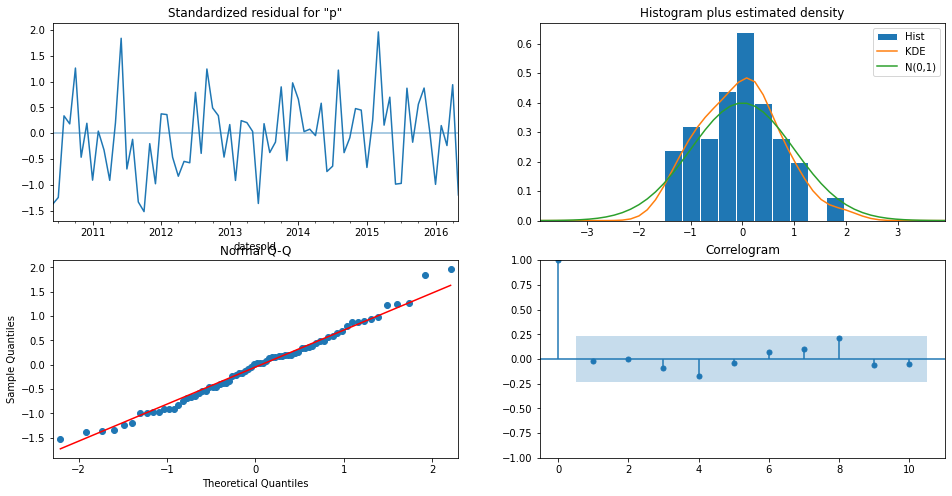

In [33]:
#plot the diagnistic result
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [34]:
final_hat_avg =test.copy()
pred_SARIMA = results.get_forecast(steps=len(test))
#pred_SARIMA.predicted_mean

In [35]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test.price,pred_SARIMA.predicted_mean))
print(rmse)

41996.98799539327


In [36]:
resultsDf=pd.DataFrame()
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['SARIMA(0,1,2)(0,1,2)12'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

Test RMSE
SARIMA(0,1,2)(0,1,2)12  41996.987995

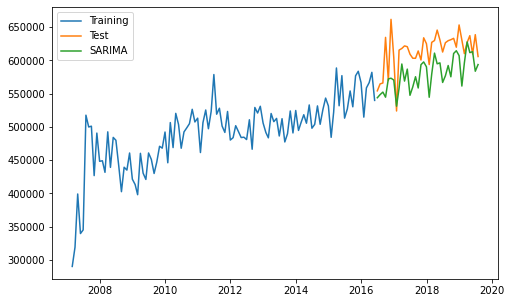

In [37]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(pred_SARIMA.predicted_mean,label="SARIMA")
plt.legend(loc = 'best')
plt.show()

# Auto Arima

**Auto ARIMA (Auto-regressive Integrated Moving Average)** is a method used to automatically find the best SARIMA model for a given time series dataset. SARIMA is a type of time series model that includes autoregressive, moving average, and differencing terms. The Auto ARIMA algorithm searches for the optimal parameters of the SARIMA model automatically, without the need for the user to specify them manually.

The algorithm uses a stepwise approach to select the best SARIMA model. It starts by testing a range of values for the non-seasonal parameters (p, d, and q) and selects the model with the lowest AIC value. Then, it tests a range of values for the seasonal parameters (P, D, and Q) and selects the model with the lowest AIC value. Finally, it combines the non-seasonal and seasonal components to form the final SARIMA model.

Auto ARIMA can handle both non-seasonal and seasonal time series data and can automatically identify the optimal number of differences needed to make the data stationary. This method is particularly useful for complex time series data with multiple seasonalities, where manually specifying the SARIMA model parameters can be difficult.

In [38]:
from pmdarima.arima import auto_arima

In [39]:

arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2422.985, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2380.564, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2363.862, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2409.526, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2365.729, Time=0.46 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2365.639, Time=0.81 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2382.120, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2366.342, Time=1.15 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2371.902, Time=0.17 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2363.877, Time=0.72 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2356.649, Time=0.44 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=2435.039, Time=0.17 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=2357.906, Time=0.60 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2357.515, Time=1.13 sec
 ARIMA(0,1,2)(1,1,0

 (0,1,2)(0,1,1)[12] is a monthly time series model with no autoregressive or seasonal autoregressive component, one seasonal moving average term, and two non-seasonal moving average terms. 

In [40]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  112
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1174.324
Date:                              Fri, 07 Apr 2023   AIC                           2356.649
Time:                                      22:37:34   BIC                           2367.029
Sample:                                  02-28-2007   HQIC                          2360.849
                                       - 05-31-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3703      0.078     -4.755      0.000      -0.523      -0.218
ma.L2          0.1243      0.071      1.760      0.078      -0.014       0.263
ma.S.L12      -0.7504      0.087     -8.617      0.000      -0.921      -0.580
sigma2      1.049e+09   3.84e-11   2.73e+19      0.000    1.05e+09    1.05e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.46   Jarque-Bera (JB):                 6.07
Prob(Q):                              0.23   Prob(JB):                         0.05
Heteroskedasticity (H):               0.37   Skew:                            -0.43
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.59e+33. Standard errors may be unstable.
"""

In [41]:
prediction = pd.DataFrame(arima_model.predict(n_periods = len(test)),index=test.index)
prediction.columns = ['predicted_price']


In [42]:
rmse = sqrt(mean_squared_error(test.price,prediction['predicted_price']))
print(rmse)
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['Auto_ARIMA(0,1,2)(0,1,1)12'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

41663.812983012875


Test RMSE
SARIMA(0,1,2)(0,1,2)12      41996.987995
Auto_ARIMA(0,1,2)(0,1,1)12  41663.812983

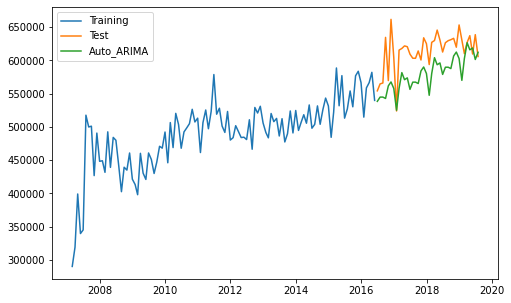

In [43]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Auto_ARIMA")
plt.legend(loc = 'best')
plt.show()

# Build Time Series models using the Prophet Library.

In [44]:

df_date2.reset_index(inplace=True)
df_prophet = pd.DataFrame()
df_prophet['ds'] = df_date2['datesold']
df_prophet['y'] = df_date2['price']
df_prophet.head()

ds         y
0 2007-02-28  290000.0
1 2007-03-31  319000.0
2 2007-04-30  399000.0
3 2007-05-31  339500.0
4 2007-06-30  345000.0

In [45]:
# the  base model from prophet

In [46]:
events = pd.DataFrame({
    'holiday': 'Great recession',
    'ds': pd.to_datetime(['2006-12-01']),
    'lower_window': 0,
    'upper_window': 580,})
#

22:37:39 - cmdstanpy - INFO - Chain [1] start processing
22:37:40 - cmdstanpy - INFO - Chain [1] done processing


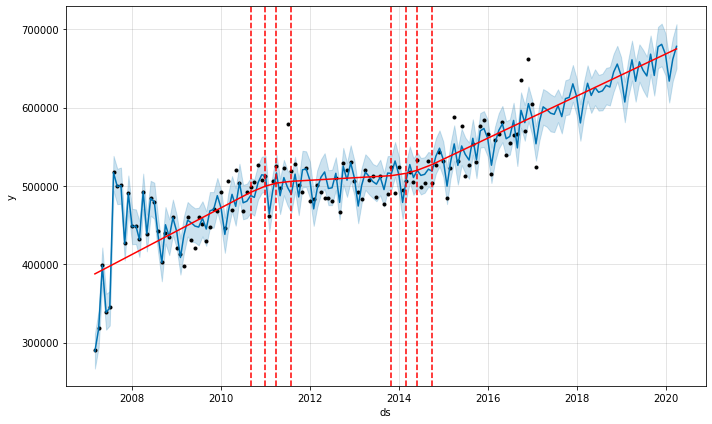

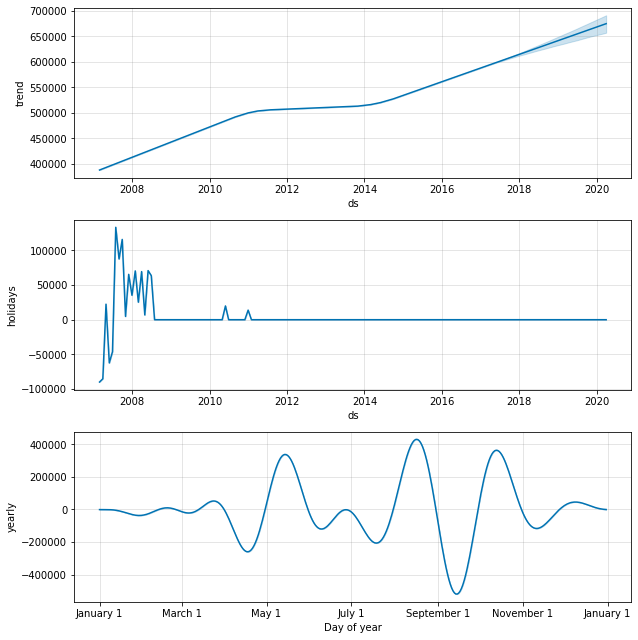

In [47]:
prophet=Prophet(holidays=events)
prophet.add_country_holidays(country_name='US')
prophet.fit(df_prophet[df_prophet['ds'] <= pd.to_datetime('2017-01-31')])
future = prophet.make_future_dataframe(periods=len(test),freq='M')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

Prophet has included the original data as the black dots and the blue line is the forecast model.

The light blue area is the confidence interval. Using the add_changepoints_to_plot function added the red lines; the vertical dashed lines are changepoints Prophet identified where the trend changed, and the solid red line is the trend with all seasonality removed. 


The components plot consists of 3 sections: the trend, the holidays, and the seasonality. The sum of those 3 components account for the entirety of the model in fact. The trend is simply what the data is showing if you subtract out all of the other components. 

The holidays plot shows the effect of all of the holidays included in the model. Holidays, as implemented in Prophet, can be thought of as unnatural events when the trend will deviate from the baseline but return once the event is over. holydays inclused the events that we choose to included it such as the great recession in US. 



In [48]:
rmse = sqrt(mean_squared_error(test['price'],forecast.tail(len(test))['yhat']))
print(rmse)

32846.06391991194


In [49]:
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['Prophet'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

Test RMSE
SARIMA(0,1,2)(0,1,2)12      41996.987995
Auto_ARIMA(0,1,2)(0,1,1)12  41663.812983
Prophet                     32846.063920

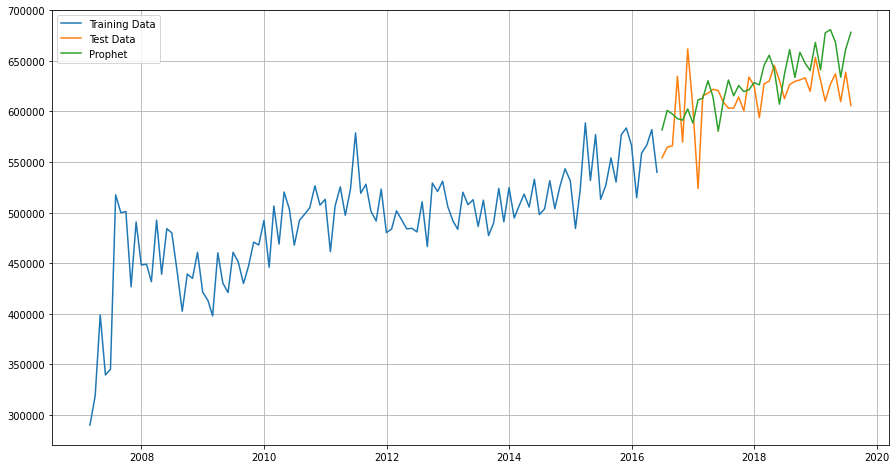

In [50]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast.tail(len(test))['yhat'],label='Prophet')
plt.legend(loc='best')
plt.grid();

In [51]:
df_prophet.columns

Index(['ds', 'y'], dtype='object')

In [52]:
# Tunning hyperparameters 

In [53]:
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [ 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, ],
    'holidays_prior_scale': [10, 12],
    
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print(all_params)
# Create a list to store rmse values for each combination
rmse = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    prophet = Prophet(**params,holidays=events)
    prophet.add_country_holidays(country_name='US')
    
    prophet.fit(df_prophet[df_prophet['ds'] <= pd.to_datetime('2017-01-31')])
    future = prophet.make_future_dataframe(periods=len(test), freq=us_bd)
    forecast = prophet.predict(future)
    rmse.append( sqrt(mean_squared_error(test['price'],forecast.tail(len(test))['yhat'])))
    
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmse
# Find the best parameters
best_params = all_params[np.argmin(rmse)]
print(best_params)

[{'changepoint_prior_scale': 0.08, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10}, {'changepoint_prior_scale': 0.08, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 12}, {'changepoint_prior_scale': 0.08, 'seasonality_prior_scale': 1, 'holidays_prior_scale': 10}, {'changepoint_prior_scale': 0.08, 'seasonality_prior_scale': 1, 'holidays_prior_scale': 12}, {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10}, {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 12}, {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'holidays_prior_scale': 10}, {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'holidays_prior_scale': 12}]


22:37:48 - cmdstanpy - INFO - Chain [1] start processing
22:37:48 - cmdstanpy - INFO - Chain [1] done processing
22:37:51 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing
22:37:55 - cmdstanpy - INFO - Chain [1] start processing
22:37:55 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] start processing
22:37:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:02 - cmdstanpy - INFO - Chain [1] start processing
22:38:03 - cmdstanpy - INFO - Chain [1] done processing
22:38:06 - cmdstanpy - INFO - Chain [1] start processing
22:38:06 - cmdstanpy - INFO - Chain [1] done processing
22:38:09 - cmdstanpy - INFO - Chain [1] start processing
22:38:10 - cmdstanpy - INFO - Chain [1] done processing
22:38:13 - cmdstanpy - INFO - Chain [1] start processing
22:38:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10}


In [54]:
tuning_results.sort_values(by='rmse').head()

changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
4                     0.50                     0.01                    10   
5                     0.50                     0.01                    12   
3                     0.08                     1.00                    12   
2                     0.08                     1.00                    10   
6                     0.50                     1.00                    10   

           rmse  
4  36327.491570  
5  36358.507138  
3  36849.311584  
2  37132.661854  
6  38425.827678

In [55]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=0.5, 
                     seasonality_prior_scale=0.01,holidays_prior_scale=10,yearly_seasonality=True,holidays=events)
auto_model.add_country_holidays(country_name='US')
    
auto_model.fit(df_prophet[df_prophet['ds'] <= pd.to_datetime('2016-01-31')])
future = auto_model.make_future_dataframe(periods=len(test), freq='M')
forecast_tuned = auto_model.predict(future)

22:38:18 - cmdstanpy - INFO - Chain [1] start processing
22:38:19 - cmdstanpy - INFO - Chain [1] done processing


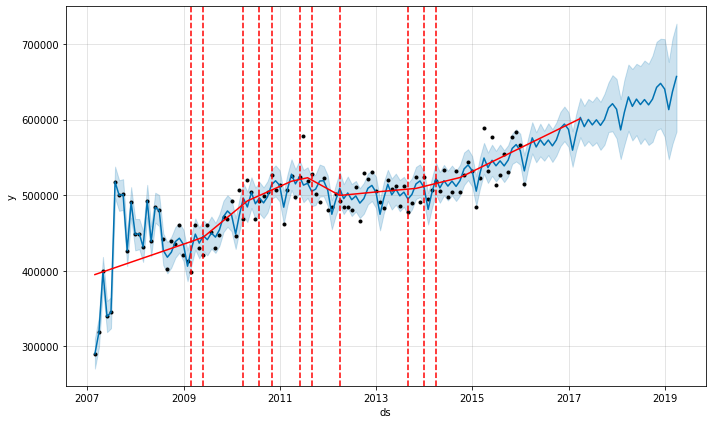

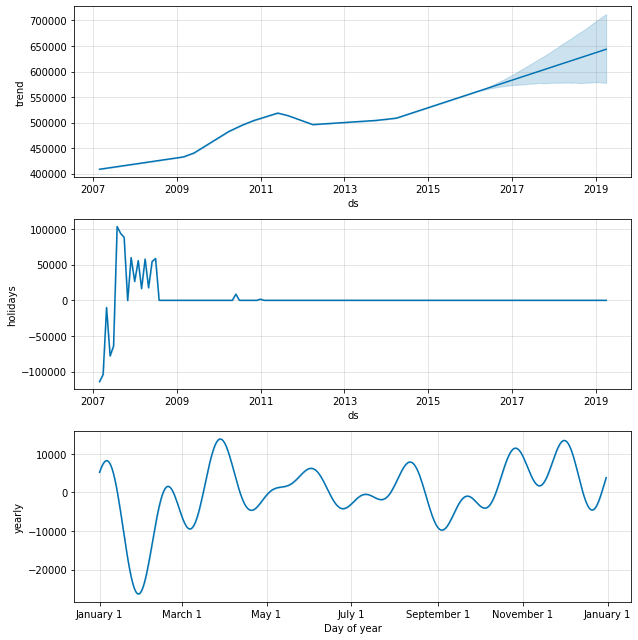

In [56]:
fig = auto_model.plot(forecast_tuned)
a = add_changepoints_to_plot(fig.gca(), auto_model, forecast)
plt.show()
fig3 = auto_model.plot_components(forecast_tuned)
plt.show()

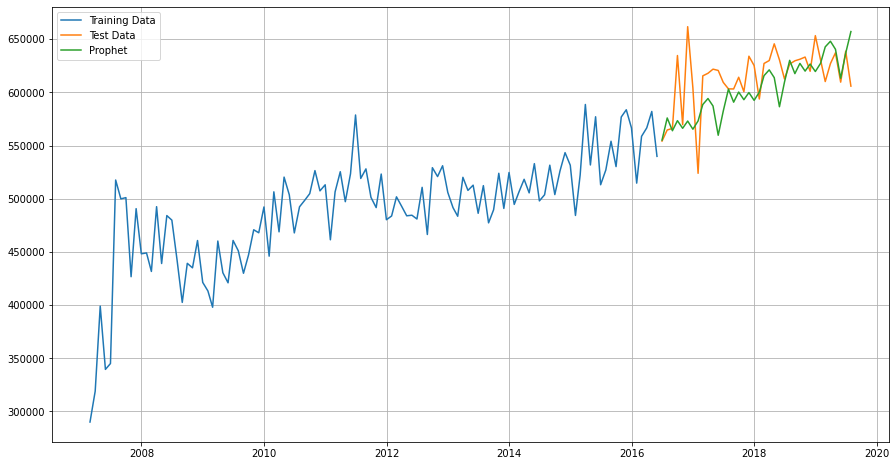

In [57]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast_tuned.tail(len(test))['yhat'],label='Prophet')
plt.legend(loc='best')
plt.grid();

# Adding Regressors:
If you have independent variables apart from the target forcasted variables, you can add thems as a regressor variables.
<https://fred.stlouisfed.org/series/INTDSRUSM193N>

In [58]:
print(df_date2['datesold'][0],df_date2['datesold'].tail(1))

2007-02-28 00:00:00 149   2019-07-31
Name: datesold, dtype: datetime64[ns]


In [59]:
df=pd.read_csv('interest_rate.csv',parse_dates=['DATE'],index_col='DATE').resample('M').mean()
df_prophet['interest'] =df[(df.index >='2007-02-28') & ((df.index <='2019-07-31'))].reset_index()['INTDSRUSM193N']


In [60]:
df_unemp=pd.read_csv('Unemployment Rate.txt',header=0, sep=r',',index_col=0).T.unstack().reset_index()
#https://data.bls.gov/pdq/SurveyOutputServlet
#df_unemp


In [61]:
df_unemp.rename(columns={'level_1':'Month',0:'Unemployment_rate'},inplace=True)


In [62]:

df_unemp['date']=pd.to_datetime(df_unemp[['Year','Month']].apply(lambda x:f"{x['Month']}-{x['Year']}",axis=1))+ pd.offsets.MonthEnd()
df_unemp['date']

0     2007-01-31
1     2007-02-28
2     2007-03-31
3     2007-04-30
4     2007-05-31
         ...    
151   2019-08-31
152   2019-09-30
153   2019-10-31
154   2019-11-30
155   2019-12-31
Name: date, Length: 156, dtype: datetime64[ns]

In [63]:
df_unemp.set_index('date',inplace=True)


In [64]:
df_prophet['unemployment_rate']=df_unemp[(df_unemp.index >='2007-02-28') & ((df_unemp.index <='2019-07-31'))].reset_index()['Unemployment_rate']
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ds                 150 non-null    datetime64[ns]
 1   y                  150 non-null    float64       
 2   interest           150 non-null    float64       
 3   unemployment_rate  150 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.8 KB


## Adding one regressor - interest rate

22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:29 - cmdstanpy - INFO - Chain [1] done processing


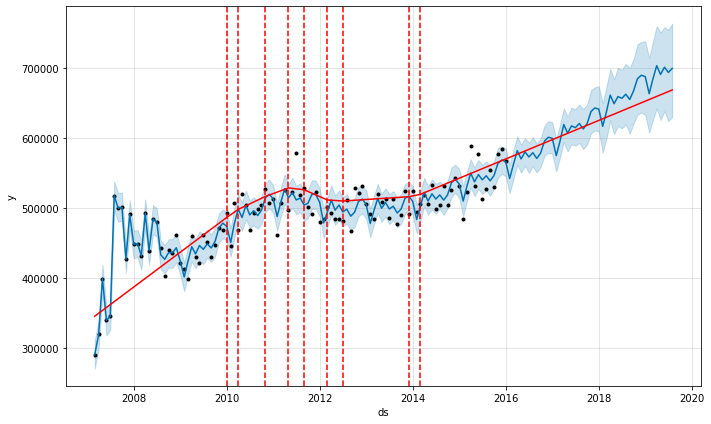

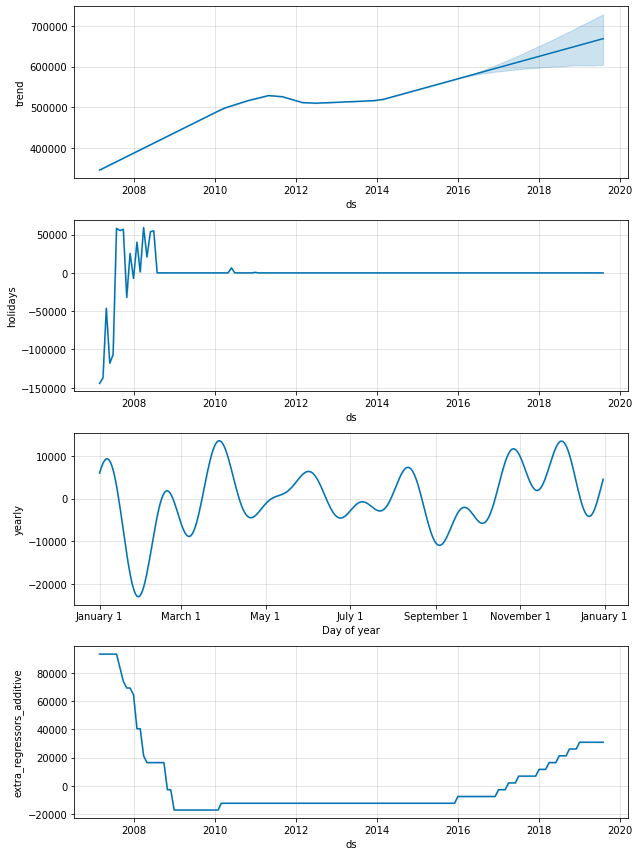

In [65]:
prophet=Prophet(changepoint_prior_scale=0.5, 
                     seasonality_prior_scale=0.01,holidays_prior_scale=10,holidays=events)
prophet.add_country_holidays(country_name='US')
prophet.add_regressor('interest')
prophet.fit(df_prophet[df_prophet['ds'] < pd.to_datetime('2016-01-31')])
future = prophet.make_future_dataframe(periods=43, freq='M')
future['interest']= df_prophet['interest']
forecast_regressor1 = prophet.predict(future)
fig = prophet.plot(forecast_regressor1)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast_regressor1)
plt.show()
fig2 = prophet.plot_components(forecast_regressor1)
plt.show()

In [66]:
rmse = sqrt(mean_squared_error(test['price'],forecast_regressor1.tail(len(test))['yhat']))
print(rmse)
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['Prophet - with interest rate'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

41479.047360990684


Test RMSE
SARIMA(0,1,2)(0,1,2)12        41996.987995
Auto_ARIMA(0,1,2)(0,1,1)12    41663.812983
Prophet                       32846.063920
Prophet - with interest rate  41479.047361

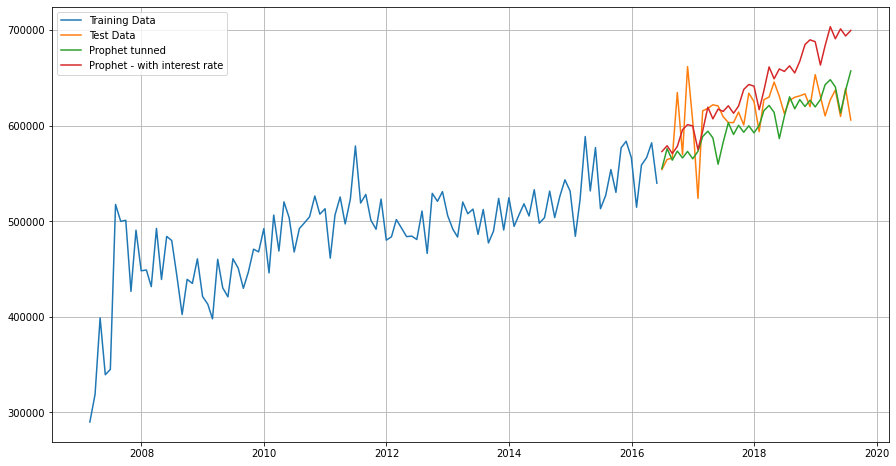

In [67]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast_tuned.tail(len(test))['yhat'],label='Prophet tunned')
plt.plot(test.index,forecast_regressor1.tail(len(test))['yhat'],label='Prophet - with interest rate')
plt.legend(loc='best')
plt.grid();

# Add Regressor: unemployment rate 

22:38:37 - cmdstanpy - INFO - Chain [1] start processing
22:38:37 - cmdstanpy - INFO - Chain [1] done processing


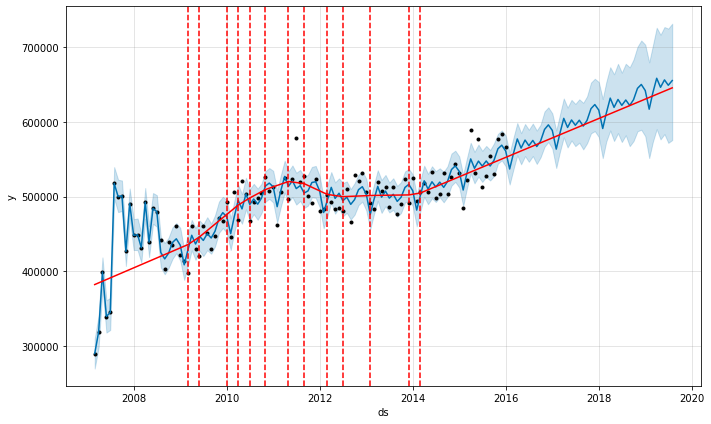

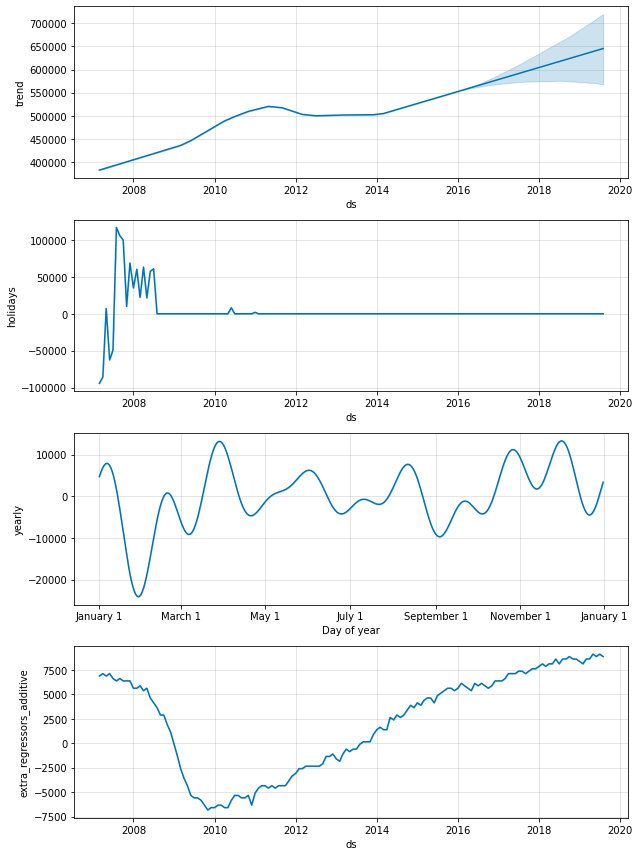

In [68]:
prophet=Prophet(changepoint_prior_scale=0.5, 
                     seasonality_prior_scale=0.01,holidays_prior_scale=10,holidays=events)
prophet.add_country_holidays(country_name='US')
prophet.add_regressor('unemployment_rate')
prophet.fit(df_prophet[df_prophet['ds'] < pd.to_datetime('2016-01-31')])
future = prophet.make_future_dataframe(periods=43, freq='M')
future['unemployment_rate']= df_prophet['unemployment_rate']
forecast_regressor2 = prophet.predict(future)
fig = prophet.plot(forecast_regressor2)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast_regressor2)
plt.show()
fig2 = prophet.plot_components(forecast_regressor2)
plt.show()

In [69]:
rmse = sqrt(mean_squared_error(test['price'],forecast_regressor2.tail(len(test))['yhat']))
print(rmse)
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['Prophet - with unemployment'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

24497.133969441686


Test RMSE
SARIMA(0,1,2)(0,1,2)12        41996.987995
Auto_ARIMA(0,1,2)(0,1,1)12    41663.812983
Prophet                       32846.063920
Prophet - with interest rate  41479.047361
Prophet - with unemployment   24497.133969

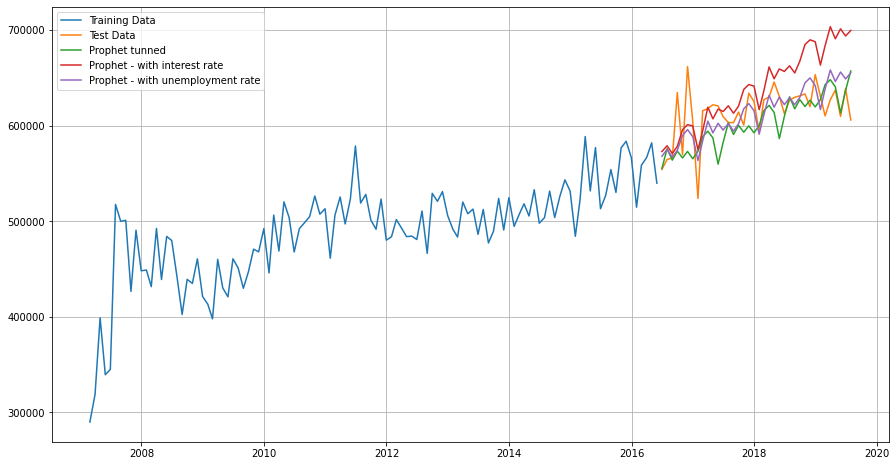

In [70]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast_tuned.tail(len(test))['yhat'],label='Prophet tunned')
plt.plot(test.index,forecast_regressor1.tail(len(test))['yhat'],label='Prophet - with interest rate')
plt.plot(test.index,forecast_regressor2.tail(len(test))['yhat'],label='Prophet - with unemployment rate')
plt.legend(loc='best')
plt.grid();

## Adding regressors both interest rate and unemployment

22:38:46 - cmdstanpy - INFO - Chain [1] start processing
22:38:47 - cmdstanpy - INFO - Chain [1] done processing


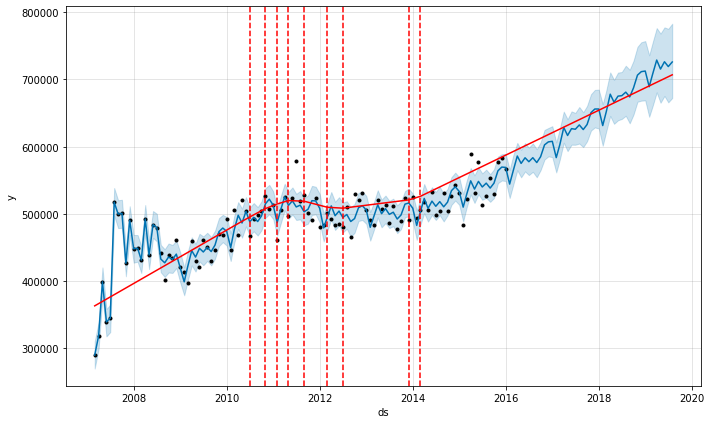

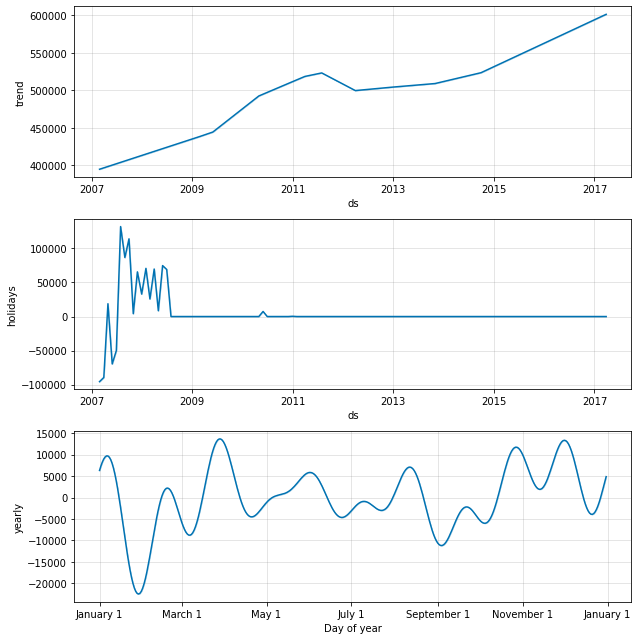

In [71]:
prophet=Prophet(changepoint_prior_scale=0.5, 
                     seasonality_prior_scale=0.01,holidays_prior_scale=10,holidays=events)
prophet.add_country_holidays(country_name='US')
prophet.add_regressor('interest')
prophet.add_regressor('unemployment_rate')
prophet.fit(df_prophet[df_prophet['ds'] < pd.to_datetime('2016-01-31')])
future = prophet.make_future_dataframe(periods=43, freq='M')
future['interest']= df_prophet['interest']
future['unemployment_rate']= df_prophet['unemployment_rate']
forecast_regressor = prophet.predict(future)
fig = prophet.plot(forecast_regressor)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast_regressor)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

In [72]:
rmse = sqrt(mean_squared_error(test['price'],forecast_regressor.tail(len(test))['yhat']))
print(rmse)
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['Prophet - with intrest and umemployment rates'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

55671.43927803282


Test RMSE
SARIMA(0,1,2)(0,1,2)12                         41996.987995
Auto_ARIMA(0,1,2)(0,1,1)12                     41663.812983
Prophet                                        32846.063920
Prophet - with interest rate                   41479.047361
Prophet - with unemployment                    24497.133969
Prophet - with intrest and umemployment rates  55671.439278

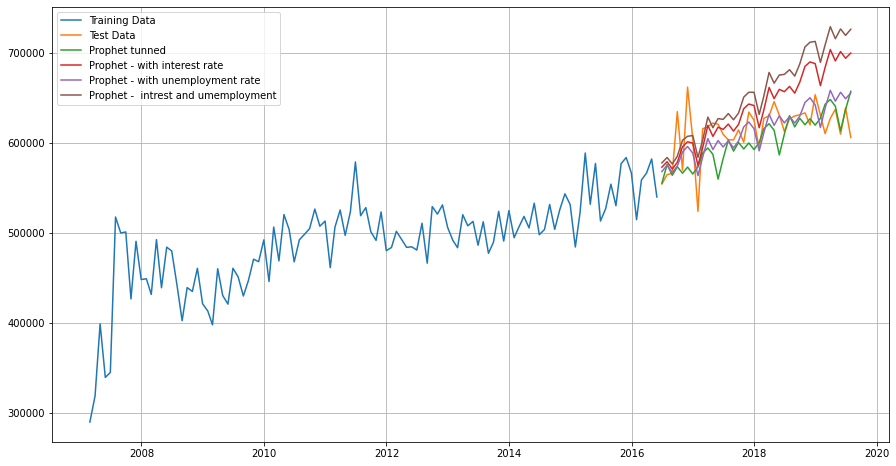

In [73]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast_tuned.tail(len(test))['yhat'],label='Prophet tunned')
plt.plot(test.index,forecast_regressor1.tail(len(test))['yhat'],label='Prophet - with interest rate')
plt.plot(test.index,forecast_regressor2.tail(len(test))['yhat'],label='Prophet - with unemployment rate')
plt.plot(test.index,forecast_regressor.tail(len(test))['yhat'],label='Prophet -  intrest and umemployment')
plt.legend(loc='best')
plt.grid();

# SARIMAX with Regressors. 

In [74]:
ex_df=df_prophet[['y','interest','unemployment_rate']]
ex_df.set_index(df_date2['datesold'].values,inplace=True)
ex_df.rename(columns={'y':'price'},inplace=True)


In [75]:
ex_df.index.freq='M'

In [76]:
ex_train=ex_df[['interest','unemployment_rate']].iloc[:112,:]
ex_test=ex_df[['interest','unemployment_rate']].iloc[112:,:]
train=ex_df[['price']].iloc[:112,:]
test=ex_df[['price']].iloc[112:,:]
ex_train.head()

interest  unemployment_rate
2007-02-28      6.25                4.5
2007-03-31      6.25                4.4
2007-04-30      6.25                4.5
2007-05-31      6.25                4.4
2007-06-30      6.25                4.6

In [77]:
## SARIMAX(0, 1, 2)	(0, 1, 2, 12)
mod = sm.tsa.statespace.SARIMAX(train['price'],exog=ex_train['interest'],
                                order=(0, 1, 2),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  112
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -834.918
Date:                            Fri, 07 Apr 2023   AIC                           1681.835
Time:                                    22:38:57   BIC                           1695.495
Sample:                                02-28-2007   HQIC                          1687.273
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
interest    7021.2347   2.62e+04      0.268      0.789   -4.44e+04    5.85e+04
ma.L1         -0.7973      0.222   

In [78]:
pred_SARIMAX = results.get_forecast(steps=len(test),exog=ex_test['interest'])
#pred_SARIMAX.predicted_mean

In [79]:
rmse = sqrt(mean_squared_error(test.price,pred_SARIMAX.predicted_mean))
print(rmse)

38451.338606155135


In [80]:
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['SARIMAX(0,1,2)(0, 1, 2, 12) with interest rate'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
#resultsDf

Test RMSE
SARIMA(0,1,2)(0,1,2)12                          41996.987995
Auto_ARIMA(0,1,2)(0,1,1)12                      41663.812983
Prophet                                         32846.063920
Prophet - with interest rate                    41479.047361
Prophet - with unemployment                     24497.133969
Prophet - with intrest and umemployment rates   55671.439278
SARIMAX(0,1,2)(0, 1, 2, 12) with interest rate  38451.338606

In [81]:
## SARIMAX(0, 1, 2)	(0, 1, 2, 12)
mod = sm.tsa.statespace.SARIMAX(train['price'],exog=ex_train['unemployment_rate'],
                                order=(0, 1, 2),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  112
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -834.310
Date:                            Fri, 07 Apr 2023   AIC                           1680.621
Time:                                    22:38:59   BIC                           1694.281
Sample:                                02-28-2007   HQIC                          1686.059
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
unemployment_rate  6649.9099    1.7e+04      0.390      0.696   -2.67e+04       4e+04
ma.L1         

In [82]:
pred_SARIMAX_unemployment = results.get_forecast(steps=len(test),exog=ex_test['unemployment_rate'])
#pred_SARIMAX_unemployment.predicted_mean

In [83]:
rmse = sqrt(mean_squared_error(test.price,pred_SARIMAX_unemployment.predicted_mean))
print(rmse)
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['SARIMAX(0,1,2)(0, 1, 2, 12) with unemployment rate'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

37281.051291161006


Test RMSE
SARIMA(0,1,2)(0,1,2)12                              41996.987995
Auto_ARIMA(0,1,2)(0,1,1)12                          41663.812983
Prophet                                             32846.063920
Prophet - with interest rate                        41479.047361
Prophet - with unemployment                         24497.133969
Prophet - with intrest and umemployment rates       55671.439278
SARIMAX(0,1,2)(0, 1, 2, 12) with interest rate      38451.338606
SARIMAX(0,1,2)(0, 1, 2, 12) with unemployment rate  37281.051291

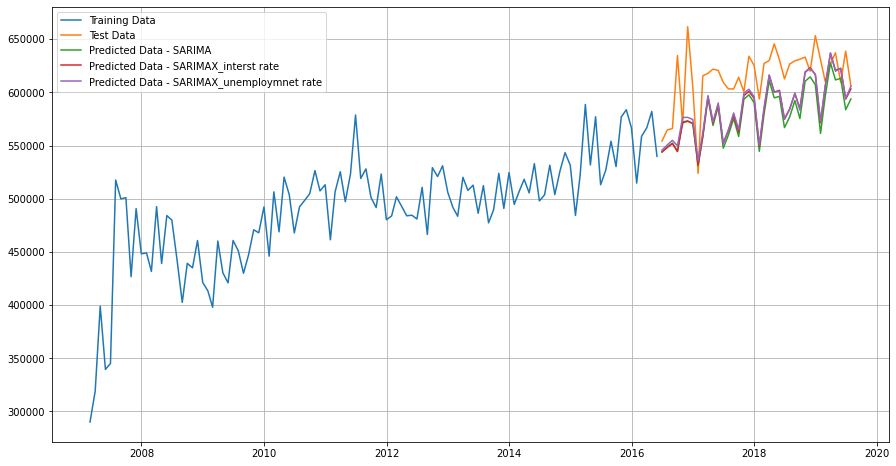

In [84]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')

plt.plot(test.index,pred_SARIMA.predicted_mean,label='Predicted Data - SARIMA')
plt.plot(test.index,pred_SARIMAX.predicted_mean,label='Predicted Data - SARIMAX_interst rate')
plt.plot(test.index,pred_SARIMAX_unemployment.predicted_mean,label='Predicted Data - SARIMAX_unemploymnet rate')
plt.legend(loc='best')
plt.grid();

In [85]:
## SARIMAX(0, 1, 2)	(0, 1, 2, 12)
mod = sm.tsa.statespace.SARIMAX(train['price'],exog=ex_train['unemployment_rate'],
                                order=(0, 1, 2),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                price   No. Observations:                  112
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -977.400
Date:                              Fri, 07 Apr 2023   AIC                           1964.800
Time:                                      22:39:02   BIC                           1976.955
Sample:                                  02-28-2007   HQIC                          1969.686
                                       - 05-31-2016                                         
Covariance Type:                                opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
unemployment_rate  6649.9099   1.21e+04      0.548      0.584   -1.71e+04    3.04e+0

In [86]:
pred_SARIMAX1_unemployment = results.get_forecast(steps=len(test),exog=ex_test['unemployment_rate'])
#pred_SARIMAX1_unemployment.predicted_mean

In [89]:
rmse = sqrt(mean_squared_error(test.price,pred_SARIMAX1_unemployment.predicted_mean))
#print(rmse)
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['SARIMAX(0,1,2)(0, 1, 1, 12) with unemployment rate'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf.sort_values(by='Test RMSE')

Test RMSE
Prophet - with unemployment                         24497.133969
Prophet                                             32846.063920
SARIMAX(0,1,2)(0, 1, 2, 12) with unemployment rate  37281.051291
SARIMAX(0,1,2)(0, 1, 2, 12) with interest rate      38451.338606
SARIMAX(0,1,2)(0, 1, 1, 12) with unemployment rate  41224.575814
SARIMAX(0,1,2)(0, 1, 1, 12) with unemployment rate  41224.575814
SARIMAX(0,1,2)(0, 1, 1, 12) with unemployment rate  41224.575814
Prophet - with interest rate                        41479.047361
Auto_ARIMA(0,1,2)(0,1,1)12                          41663.812983
SARIMA(0,1,2)(0,1,2)12                              41996.987995
Prophet - with intrest and umemployment rates       55671.439278

## The winner is the Prophet model with the unemployment rate:   
Looking at the results, we can see that the SARIMAX model with an order of (0,1,2) and a seasonal order of (0,1,2,12) that includes the interest rate as an exogenous variable has the lowest Test RMSE value of 38,451 for ARIMA methods. This indicates that this model provides accepted performance in predicting the time series data compared to the other models. Prophet model with unemployment rate as exogenous valiable has the lowest rmse 24497. Overall, I would recommend further evaluating Prophet model with the unemployment rate as an exogenous variable. 
